In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the datasets
train_df = pd.read_csv('../processed_data/train_processed_with_dummies.csv')
test_df = pd.read_csv('../processed_data/valid_processed_with_dummies.csv')

train_X, train_y = train_df.iloc[1:, 1:-1], train_df.iloc[1:, -1:]
train_X = torch.Tensor(train_X.to_numpy(dtype=float))
train_y = torch.Tensor(train_y.to_numpy(dtype=float))

test_X, test_y = test_df.iloc[:, 1:-1], test_df.iloc[:, -1:]
test_X = torch.Tensor(test_X.to_numpy(dtype=float))
test_y = torch.Tensor(test_y.to_numpy(dtype=float))

train = TensorDataset(train_X, train_y)
train_iter = DataLoader(train, batch_size = 32)
test = TensorDataset(test_X, test_y)
test_iter = DataLoader(test, batch_size = 32)

In [3]:
# Regression Model
features = train_X.shape[1]

regression = nn.Sequential(nn.Linear(features, 1))

features

223

In [4]:
# Multi-layer Proceptron
MLP = nn.Sequential(nn.Flatten(),
                    nn.Linear(features, 256), nn.ReLU(),
                    nn.Linear(256, 1))

In [5]:
# Training
def train(net, train_iter, epochs, loss, lr, device):
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    loss_metric = []

    for epoch in range(epochs):
        for _,(X ,y) in enumerate(train_iter):
            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)
            l = loss(y_hat, y)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        
        log_rmse = torch.sqrt(loss(torch.log(y_hat),
                           torch.log(y)))
        loss_metric.append(log_rmse.item())
    print(f'loss: {log_rmse.item()}')
    return loss_metric

loss: 0.3277241587638855


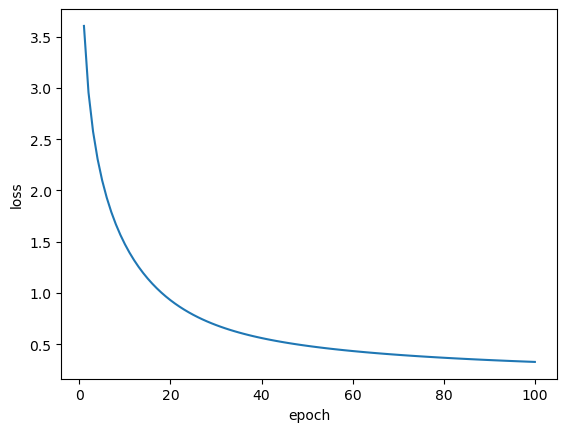

In [6]:
epochs, lr = 100, 0.01
loss = nn.MSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_metric = train(regression, train_iter, epochs, loss, lr, device)

fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, epochs, epochs)
ax.plot(x, loss_metric)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

loss: 0.1967681348323822


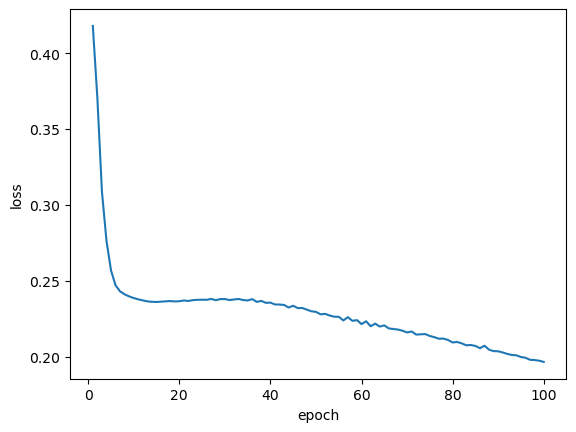

In [7]:
loss_metric = train(MLP, train_iter, epochs, loss, lr, device)

fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, epochs, epochs)
ax.plot(x, loss_metric)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

In [8]:
# Validation
def valid(net, test_iter, device, loss):
    net.eval()
    with torch.no_grad():
        net = net.to(device)
        l = 0
        for X ,y in test_iter:
            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)
            log_rmse = torch.sqrt(loss(torch.log(y_hat),
                           torch.log(y)))
            l = l + log_rmse.item()
        
    return l / len(list(test_iter))


In [9]:
regression_valid = valid(regression, test_iter, device, loss)
MLP_valid = valid(MLP, test_iter, device, loss)

print(f'Regression Validation Loss: {regression_valid}')
print(f'MLP Validation Loss: {MLP_valid}')

Regression Validation Loss: 0.26601377555302214
MLP Validation Loss: 0.17321771809032985


In [12]:
# Generate Kaggle Results
test_df = pd.read_csv('../processed_data/test_processed_with_dummies.csv')

test_X, id = test_df.iloc[:, 1:], test_df.iloc[:, :1]
test_X = torch.Tensor(test_X.to_numpy(dtype=float))
print(test_X.shape)

test_iter = DataLoader(test_X)
ans = []

regression.cpu()
regression.eval()
with torch.no_grad():
    for X in test_iter:
        y = regression(X)
        ans.append(float(y))

ans = pd.DataFrame({'label':ans})
sub = pd.concat([id, ans], axis=1)

sub.to_csv('submission_regression.csv', index=False)



ans = []

MLP.cpu()
MLP.eval()
with torch.no_grad():
    for X in test_iter:
        y = MLP(X)
        ans.append(float(y))

ans = pd.DataFrame({'label':ans})
sub = pd.concat([id, ans], axis=1)

sub.to_csv('submission_MLP.csv', index=False)

torch.Size([1459, 223])
